In [3]:
# GAN

# 1 import library
import imageio
import matplotlib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms


# matplotlib style 설정
matplotlib.style.use("ggplot")
# plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 2 variable setting
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

In [5]:
# 3 mnist download
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = datasets.MNIST(
    root="data2", train=True, transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

In [6]:
# 4 Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [7]:
# 5 Descriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
# 6 object setting
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [9]:
# 7 loss function, optimizer setting
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [10]:
# 8 image save function
def save_generator_image(image, path):
    save_image(image, path)

In [11]:
# 9 descriminator train function
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [12]:
# 10 generator train function
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [15]:
# 11 model training
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    idxh = 0
    for idx, data in enumerate(train_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device).detach())
            data_real = image
            loss_d += train_discriminator(optim_d, image, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device).detach())
        loss_g += train_generator(optim_g, data_fake)
        idxh = idx

    generated_image = generator(torch.randn(sample_size, nz).to(device)).cpu().detach()
    generated_image = make_grid(generated_image)
    save_generator_image(generated_image, f"data2/generated_images_{epoch}.png")
    images.append(generated_image)
    epoch_loss_g = loss_g / idxh
    epoch_loss_d = loss_d / idxh
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: 3.40554142, Discriminator loss: 1.19158053
Epoch 1 of 200
Generator loss: 2.34370756, Discriminator loss: 0.99131310
Epoch 2 of 200
Generator loss: 2.33423686, Discriminator loss: 0.78651118
Epoch 3 of 200
Generator loss: 1.34494126, Discriminator loss: 1.14759362
Epoch 4 of 200
Generator loss: 3.87813282, Discriminator loss: 0.84375012
Epoch 5 of 200
Generator loss: 2.74473333, Discriminator loss: 1.02631068
Epoch 6 of 200
Generator loss: 1.72398365, Discriminator loss: 0.91461843
Epoch 7 of 200
Generator loss: 2.92544889, Discriminator loss: 1.10974932
Epoch 8 of 200
Generator loss: 1.82098484, Discriminator loss: 0.92148274
Epoch 9 of 200
Generator loss: 1.45304501, Discriminator loss: 1.01893234
Epoch 10 of 200
Generator loss: 1.79675043, Discriminator loss: 0.95732278
Epoch 11 of 200
Generator loss: 2.06928968, Discriminator loss: 1.13366783
Epoch 12 of 200
Generator loss: 1.32091761, Discriminator loss: 1.03798187
Epoch 13 of 200
Generator loss: 2.5

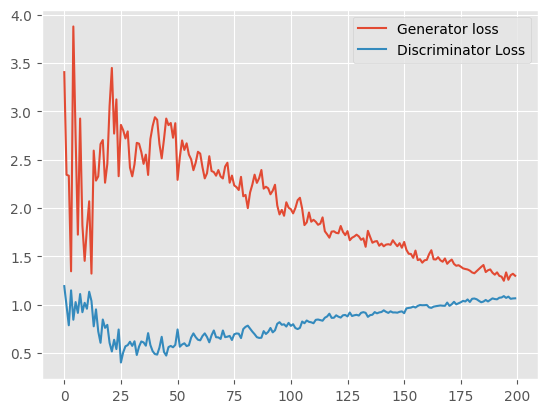

In [16]:
# 12 pltting
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label="Generator loss")
losses_d = [fl.item() for fl in losses_d]
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()
plt.show()

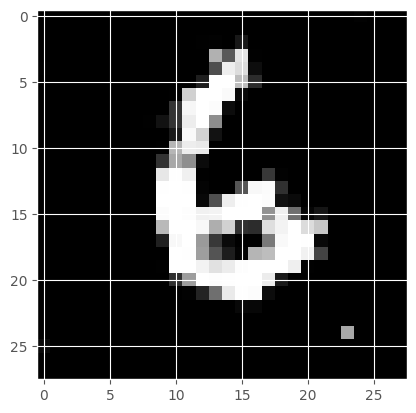

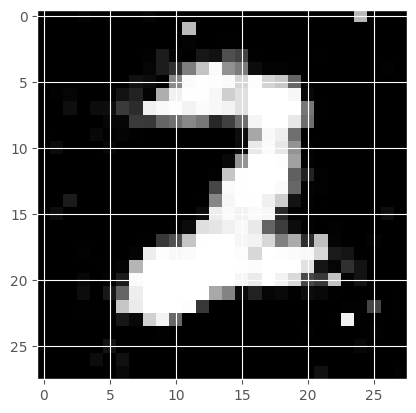

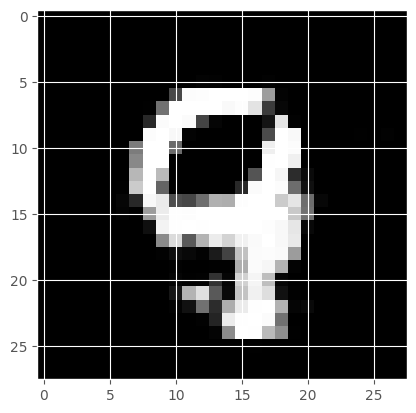

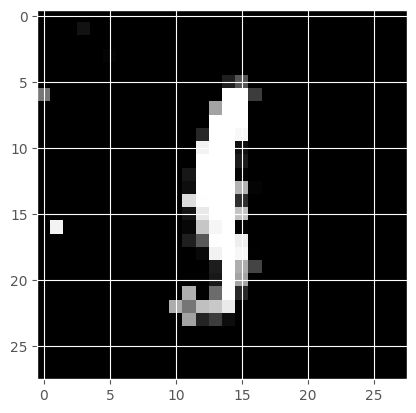

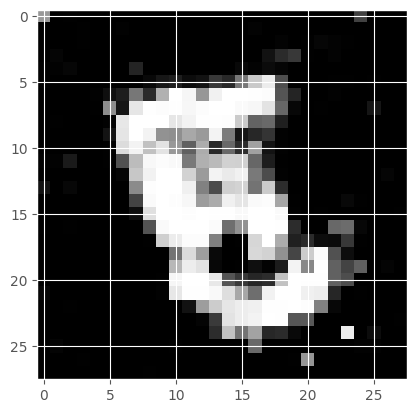

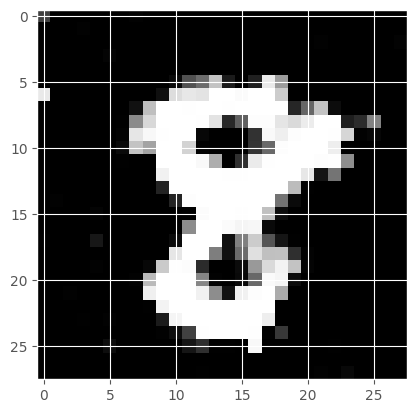

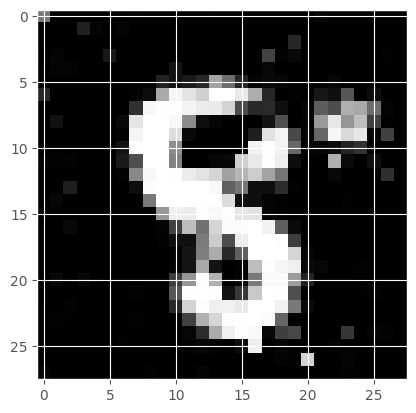

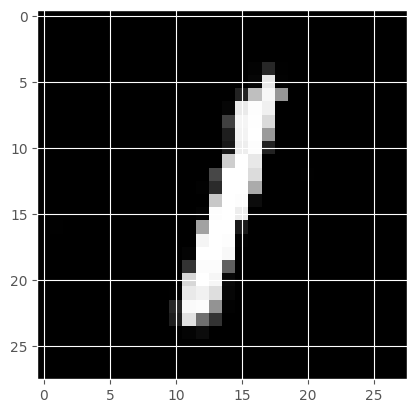

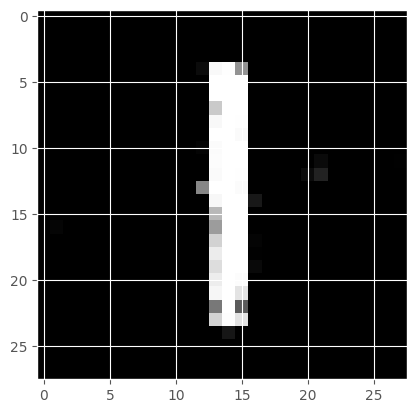

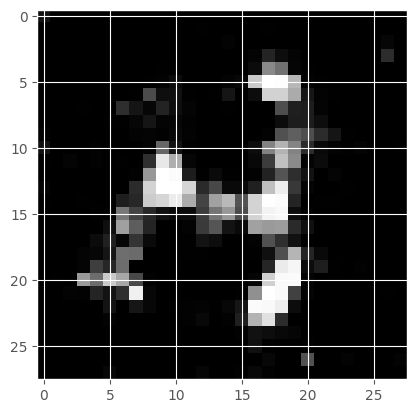

In [17]:
# 13 image gereration
import numpy as np

fake_images = generator(torch.randn(batch_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().detach().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap="gray")
    plt.savefig(f"data2/fake_images_img_{i}.png")
    plt.show()